<a href="https://colab.research.google.com/github/ahcamachod/integracion-sql-python/blob/aula-3/Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan de Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estructurando la tabla

**Meteora** es una tienda online que vende ropa y accesorios de diversas marcas por todos los estados mexicanos, y el objetivo es entender sus bases de datos y poder exhibir la información relevante para auxiliar en la toma de decisiones del negocio.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text, inspect

**Sobre las tablas**

* items: Entidad que informa lo que fue vendido. Contiene la información de precio, cantidad, hacia donde se despacha y el costo del envío.
* pedidos: Entidad que habla del pedido en sí, contiene la información sobre los vendedores, precio del pedido y la fecha de la venta.
* productos: Entidad que contiene las características de cada uno de los productos comercializados por la tienda.
* vendedores: Entidad que informa el nombre de los vendedores.

In [ ]:
url_items = 'https://gist.githubusercontent.com/ahcamachod/4baf71bc6e2a8411d0c374d5cb63eaa6/raw/'
url_pedidos = 'https://gist.githubusercontent.com/ahcamachod/c710044e6da5377ec50dbadacdc6941c/raw/'
url_productos = 'https://gist.githubusercontent.com/ahcamachod/eedefc055067f90b57ec722a7171be9e/raw/'
url_vendedores = 'https://gist.githubusercontent.com/ahcamachod/a1b2f2bc97adb2af1b17659bdbb0676e/raw/'

In [ ]:
items = pd.read_csv(url_items)
pedidos = pd.read_csv(url_pedidos)
productos = pd.read_csv(url_productos)
vendedores = pd.read_csv(url_vendedores)

In [ ]:
engine = create_engine('sqlite:///:memory:')

In [ ]:
items.to_sql('items', engine, if_exists='replace', index=False)
pedidos.to_sql('pedidos', engine, if_exists='replace', index=False)
productos.to_sql('productos', engine, if_exists='replace', index=False)
vendedores.to_sql('vendedores', engine, if_exists='replace', index=False)

5

In [ ]:
inspector = inspect(engine)
print(inspector.get_table_names())

['items', 'pedidos', 'productos', 'vendedores']


# 2. Primeras consultas

Vamos a entender la característica de los productos comercializados por Meteora, analizando la **condición** de los productos vendidos.

In [ ]:
query = '''SELECT CONDICION FROM PRODUCTOS'''

In [ ]:
with engine.connect() as conexion:
  consulta = conexion.execute(text(query))
  resultado = consulta.fetchall()

pd.DataFrame(resultado,columns = consulta.keys())

,condicion
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [ ]:
def sql_df(query):
  with engine.connect() as conexion:
    consulta = conexion.execute(text(query))
    resultado = consulta.fetchall()
  return pd.DataFrame(resultado,columns = consulta.keys())

In [ ]:
query = '''SELECT CONDICION, COUNT(*) AS cantidad
            FROM PRODUCTOS
            GROUP BY CONDICION;'''

df_productos = sql_df(query)
df_productos

,condicion,cantidad
0,Nuevo con etiqueta,22
1,Nuevo sin etiqueta,7
2,Usado,176


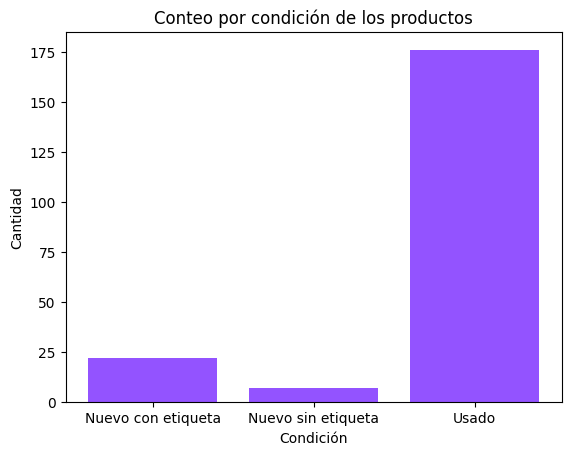

In [ ]:
plt.bar(df_productos['condicion'],df_productos['cantidad'],color='#9353FF')
plt.title('Conteo por condición de los productos')
plt.xlabel('Condición')
plt.ylabel('Cantidad')
plt.show()

Ahora necesitamos generar un ranking de los productos que fueron más pedidos por **cantidad** para entender la necesidad de contar con un inventario de productos en la tienda.

In [ ]:
sql_df('SELECT * FROM PRODUCTOS LIMIT 4')

,id_producto,producto,precio,marca,sku,condicion
0,21244,Lentes Marco Blue,1120,D&G Dolce & Gabbana,209297,Usado
1,9981,Cartera Coral Verde,4000,Givenchy,278612,Usado
2,84176,Camisa Cuadros Verde,310,Joe Fresh,322482,Usado
3,47475,Pantalon Design Negro,1490,Burberry,263658,Usado


In [ ]:
sql_df('SELECT * FROM ITEMS LIMIT 4')

,id_factura,id_producto,id_pedido,cantidad,valor_unitario,valor_total,Estado,envio
0,1,41518,341,3,260,780,MX-YU,156.0
1,2,4307,1174,5,6175,30875,MX-NL,6175.0
2,3,22407,1399,3,200,600,MX-SO,120.0
3,4,3820,1652,6,139,834,MX-MO,166.8


In [ ]:
query = ''' SELECT A.PRODUCTO, SUM(B.CANTIDAD) AS cantidad FROM PRODUCTOS A, ITEMS B
            WHERE A.ID_PRODUCTO = B.ID_PRODUCTO
            GROUP BY A.PRODUCTO
            ORDER BY cantidad DESC;'''
df_productos = sql_df(query)
df_productos.head(10)

,producto,cantidad
0,Vestido Recortes Colores,795
1,Pantalon Jeans Costuras,755
2,Falda Pliegues Negra,751
3,Pantalon Design Negro,750
4,Falda Midi Cinturon,549
5,Vestido Nude Recto,547
6,Blusa Manga Estampa,536
7,Camisa Cuadros Azul,511
8,Cropped Design Pb,508
9,Bomber Tricot Off,507


In [ ]:
ct_productos = df_productos.head(10).sort_values('cantidad',ascending=True)
ct_productos

,producto,cantidad
9,Bomber Tricot Off,507
8,Cropped Design Pb,508
7,Camisa Cuadros Azul,511
6,Blusa Manga Estampa,536
5,Vestido Nude Recto,547
4,Falda Midi Cinturon,549
3,Pantalon Design Negro,750
2,Falda Pliegues Negra,751
1,Pantalon Jeans Costuras,755
0,Vestido Recortes Colores,795


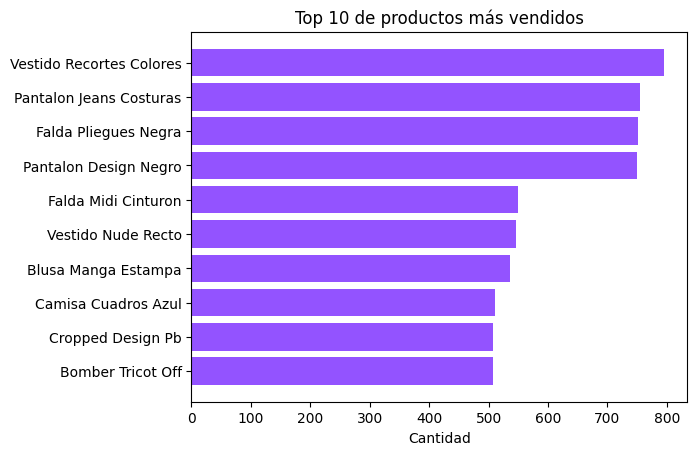

In [ ]:
plt.barh(ct_productos['producto'],ct_productos['cantidad'],color='#9353FF')
plt.title('Top 10 de productos más vendidos')
plt.xlabel('Cantidad')
plt.show()

# 3. Aplicando filtros

Vamos a iniciar un análisis del desempeño del **equipo de ventas** de Meteora. La intención es entender cuál fue el comportamiento de las ventas para cada uno de los vendedores el **año anterior** para poder aplicar promociones y bonos por el cumplimiento de metas para el equipo durante el año actual que es 2024

Para entender el desempeño de las ventas para cada uno de los vendedores en el año 2023, es necesario trabajar únicamente con los datos que están presentes en el año mencionado.

# 4. Avanzando en las relaciones

Meteora desea incrementar sus ventas en la ciudad de México **CDMX**, porque considera que es una ciudad propicia para las ventas ya que tiene una buena concentración de personas y de mercado también.

Pero, ¿no será que CDMX por sí sola no tiene muchas más ventas con respecto a los otros estados?

Una de las acciones que Meteora pretende seguir para las ventas en CDMX es la de escoger a dos de sus vendedores para que ellos **enfoquen sus ventas** allí. Para esta eleccion sería interesante traer a los profesionales que **más ventas hayan realizado** para las personas de la región.